In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 两个成分

假设有两个成分，每个成分的物理参数均匀分布。两个成分的激发温度、速度、速度宽度、峰值广深分别为$T_{\text{ex},i}$, $v_i$, $\Delta v_i$, $\tau_{\text{p},i}$, $i=1,2$.

光深为
$$\tau_i(v) = \tau_{\text{p},i}\;\exp\left(-\frac{(v-v_i)^2}{2\Delta v_i^2}\right).$$

单个成分的谱线强度轮廓为
$$I_{i}(v) = B\left(v, T_{\text{ex}, i}\right) \left(1-e^{-\tau_i(v)}\right).$$
下文为了简单起见，假定$B\left(v, T_{\text{ex}, i}\right)=T_\text{ex}$.

假定光线先通过第一个成分，再通过第二个成分到达观测者，则观测者看到的谱线轮廓为
$$I_\text{obs}(v) = I_1(v) e^{-\tau_2(v)} + I_2(v).$$

# 多个成分

不断使用上述公式，即可得到多个成分对应的谱线轮廓。把需要模拟的区域划分成很多个微元，通过这样的计算即可得到预期的谱线轮廓。

# 重要的参数

1. 温度分布 $T(r)$
1. 速度分布 $v(r)$
1. 微观湍动致宽 $\Delta v(r)$
1. 总柱密度 $N$

通过参数化的模型，应该能拟合出相关的参数，更定量地认识观测的源的物理状态。可参考：Zhou et al. 1993, Myers et al. 1996。

In [2]:
# 这里的代码只是示例，如果用于拟合的话计算速度可能比较慢。

def gauss(v, vi=None, dv=None):
    return np.exp(-0.5*((v-vi)/dv)**2)

def Iv(v, Tex=None, vi=None, dv=None, taup=None):
    tau = taup * gauss(v, vi, dv)
    return Tex * (1 - np.exp(-tau))

def compose(v, p1=None, p2=None):
    tau2 = p2['taup'] * gauss(v, p2['vi'], p2['dv'])
    return Iv(v, **p1) * np.exp(-tau2) + Iv(v, **p2)

def compose_multiple(v, p_s=None):
    I0 = Iv(v, **p_s[0])
    for p in p_s[1:]:
        tau = p['taup'] * gauss(v, p['vi'], p['dv'])
        exp_mtau = np.exp(-tau)
        I0 = I0 * exp_mtau + p['Tex'] * (1 - exp_mtau)
    return I0

In [3]:
tau_tot = 5.0
nhalf = 100

v_blue = linspace(0, -10, num=nhalf)
v_red = -v_blue[::-1]
vel = np.concatenate((v_blue, v_red))

n = len(vel)
# 作为示例，这里人为指定了一种温度和速度的分布来模拟内落过程。
# 实际的分布需要通过更准确的物理模型得到。
params_a = [
    {'Tex': 10+abs(v)*5,
     'vi': v,
     'dv': 2,
     'taup': tau_tot/n,
    }
    for v in vel
]
p_envelope = {
    'Tex': 10,
    'vi': 0,
    'dv': 2,
    'taup': 3,
}
# 是否引入额外的冷包层吸收？
#params_a.insert(0, p_envelope)
#params_a.append(p_envelope)

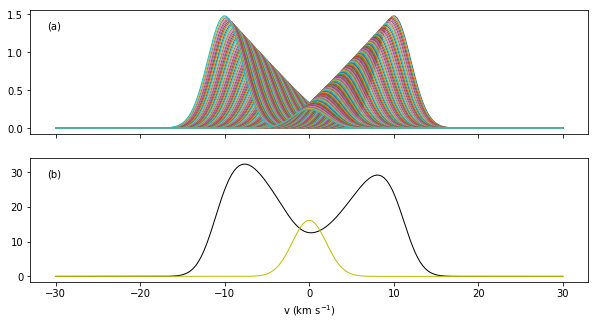

In [4]:
v = linspace(-30, 30, num=200)

f = figure(figsize=(10,5))
ax = f.add_subplot(2,1,1)
ax.set_xticklabels([])
ax.text(0.03, 0.85, '(a)', transform=ax.transAxes)
for p in params_a:
    I = Iv(v, **p)
    ax.plot(v, I, lw=1)
Iout = compose_multiple(v, p_s=params_a)
prof_envelope = max(Iout)/2 * gauss(v, vi=p_envelope['vi'], dv=p_envelope['dv'])
ax = f.add_subplot(2,1,2)
ax.set_xlabel('v (km s$^{-1}$)')
ax.text(0.03, 0.85, '(b)', transform=ax.transAxes)
ax.plot(v, Iout, lw=1, color='black')
ax.plot(v, prof_envelope, lw=1, color='y')

上面的图 panel (a) 画出了每个微元独立存在时的谱线轮廓，panel (b) 画出了观测到的谱线轮廓。黄色线是 envelope 的光薄轮廓。

# 问题

1. 两个峰的不对称度 (强度比) 最大能到多少？由哪些因素决定？
2. 两个峰之间的距离由哪些因素决定？
3. 每个峰的宽度由哪些因素决定？
4. “峰谷比”最多能到多少？
5. 什么情况下没有谷，而只有一个略显不对称的谱线轮廓？

# 下面是仅包含两个速度成分的例子

理解低温成分对高温成分的吸收，以及由此引起的不对称谱线轮廓。

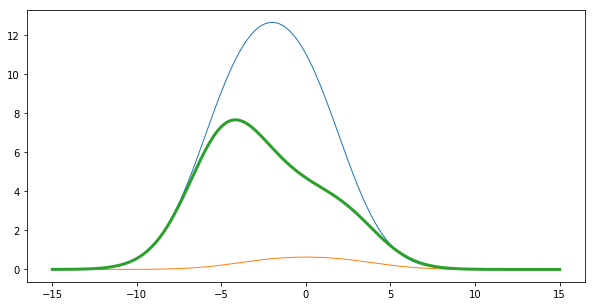

In [5]:
params_1 = {
    'Tex': 20,
    'vi': -2,
    'dv': 3,
    'taup': 1
}
params_2 = {
    'Tex': 1,
    'vi': 0,
    'dv': 3,
    'taup': 1
}

v = linspace(-15, 15, num=200)
I1, I2 = Iv(v, **params_1), Iv(v, **params_2)
I12 = compose(v, p1=params_1, p2=params_2)

f = figure(figsize=(10,5))
plot(v, I1, lw=1)
plot(v, I2, lw=1)
plot(v, I12, lw=3)